# run FaIR from SSP files

I have created emissions files as CSVs from each of the 8 main SSP scenarios. You can use these as a basis to make your own scenarios.

Emissions units:
- CO2 FFI (fossil fuel and industry), CO2 AFOLU: GtCO2/yr
- CH4, N2O, Sulfur, BC, OC, NOx, NOx aviation, NH3, VOC, CO: Mt/yr
- everything else: kt/yr

The NOx emissions that are erroneous in the RCMIP data files have been fixed here.

Chris Smith 12 May 2023

In [1]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch

import fair
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [2]:
fair.__version__  # should start 2.1.0 plus maybe some junk.

'2.1.0+5.g262b67c'

## Load up the natural forcing

In [3]:
natural = pd.read_csv('../forcing/natural.csv', index_col=0)
natural

,solar,volcanic
timebound,,
1750,0.102215,0.246391
1751,0.097800,0.246412
1752,0.079454,0.246420
1753,0.049376,0.246422
1754,0.013198,0.246423
...,...,...
2497,0.000000,0.000000
2498,0.000000,0.000000
2499,0.000000,0.000000


## Grab FaIR calibration v1.1

In [4]:
df_configs = pd.read_csv(
    "../fair_calibration/calibrated_constrained_parameters.csv",
    index_col=0,
)
valid_all = df_configs.index

## Define problem

In this example I will run all 8 scenarios. If you just want to run one, use a one-element list.

Good tip is to give your CSV file the same name as the scenario below, then it can be automatically read in.

In [5]:
scenarios = [
    "ssp119",
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp434",
    "ssp460",
    "ssp534",
    "ssp585",
]

In [6]:
# Define trend of historical solar forcing
trend_shape = np.ones(752)
trend_shape[:271] = np.linspace(0, 1, 271)

f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2501, 1)
f.define_scenarios(scenarios)
f.define_configs(valid_all)
species, properties = read_properties()
f.define_species(species, properties)
f.allocate()

## Fill emissions arrays with scenarios

The second line below is why it's a good idea to name your scenarios the same as the filenames

In [7]:
for scenario in scenarios:
    df_emis = pd.read_csv(f'../emissions/{scenario}.csv', index_col=0)
    for specie in df_emis.columns:
        f.emissions.loc[dict(specie=specie, scenario=scenario)] = df_emis.loc[:, specie].values[:, None]

## Quick sense check

also shows you how to access a particular specie

`valid_all[0]` is the first config of the 1001 configs. As the emissions are the same in all of them, we only need to plot the first.

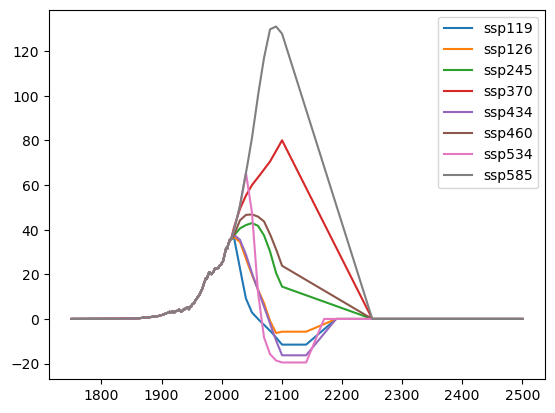

In [8]:
for scenario in scenarios:
    pl.plot(f.timepoints, f.emissions.loc[dict(scenario=scenario, config=valid_all[0], specie='CO2 FFI')], label=scenario)
pl.legend()

## Fill all of the model configs

Shouldn't need to edit any of this next cell

In [9]:
# solar and volcanic forcing
fill(
    f.forcing,
    natural.volcanic.values[:, None, None] * df_configs["scale Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    natural.solar.values[:, None, None] * df_configs["solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "c1":"c3"].values)
fill(f.climate_configs["ocean_heat_transfer"], df_configs.loc[:, "kappa1":"kappa3"].values)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["shape Sulfur"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["shape BC"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["shape OC"].values.squeeze(), specie="OC")

# methane lifetime baseline and sensitivity
fill(f.species_configs["unperturbed_lifetime"], 9.9978941686, specie="CH4")
fill(f.species_configs["ch4_lifetime_chemical_sensitivity"], 0.000254099313466019, specie="CH4")
fill(f.species_configs["ch4_lifetime_chemical_sensitivity"], -0.000722664594950932, specie="N2O")
fill(f.species_configs["ch4_lifetime_chemical_sensitivity"], 0.00161926353368172, specie="VOC")
fill(f.species_configs["ch4_lifetime_chemical_sensitivity"], -0.00251106743984572, specie="NOx")
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"], 
    -0.0000053273763975757, 
    specie="Equivalent effective stratospheric chlorine"
)
fill(f.species_configs["lifetime_temperature_sensitivity"], -0.0408)

# emissions adjustments for N2O and CH4, overridden from defaults. 
fill(f.species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct radiative efficiency
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs[f"ari {specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs[f"scale {specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs["scale minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone radiative efficiency
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs[f"o3 {specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs["co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

## initialise

In [10]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## run

In [11]:
f.run()

Running 8008 projections in parallel:   0%|          | 0/751 [00:00<?, ?timesteps/s]

## if you want to save data

FaIR is quick, but it still takes 3 minutes to run 8 scenarios x 1001 configs x 750 years. You probably don't want to wait for this every time. This creates a netCDF file that you can load in and analyse in a new script.

This is a huge file, so is not provided as part of the git repository.

In [12]:
os.makedirs('../output', exist_ok=True)
f.to_netcdf('../output/results.nc')

## analyse

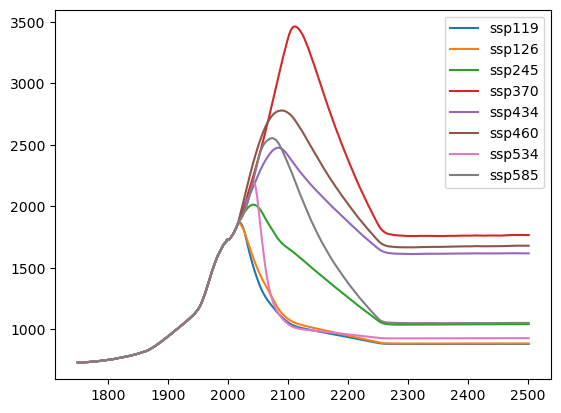

In [13]:
for scenario in scenarios:
    pl.plot(f.timebounds, f.concentration.loc[dict(scenario=scenario, config=valid_all[0], specie='CH4')], label=scenario)
pl.legend()

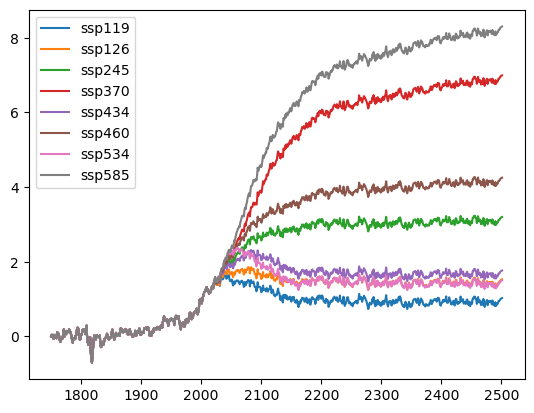

In [14]:
for scenario in scenarios:
    pl.plot(f.timebounds, f.temperature.loc[dict(scenario=scenario, config=valid_all[1], layer=0)], label=scenario)
pl.legend()